In [1]:
import requests
import numpy as np
import pandas as pd
import psycopg2
from datetime import datetime, date, time
import string
import time
from dateutil import parser
import re
import pytz    
import tzlocal 
import matplotlib.pyplot as plt
import calendar
import matplotlib

pd.options.display.max_columns = 999
%matplotlib inline

# Weather data

In [64]:
# importig the raw file
DF = pd.read_csv('data/RNT.txt')

/Users/eduardodeangelis/anaconda2/envs/python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [65]:
DF.columns

Index(['station', 'valid', 'tmpf', ' dwpf', ' relh', ' drct', ' sknt', ' p01i',
       ' alti', ' mslp', ' vsby', ' gust', ' skyc1', ' skyc2', ' skyc3',
       ' skyc4', ' skyl1', ' skyl2', ' skyl3', ' skyl4', ' wxcodes', ' metar'],
      dtype='object')

In [66]:
#dropping unuseful columns
DF = DF.drop(columns = [' skyc2', ' skyc3',' skyc4',' skyl2', ' skyl3',' skyl4'])
DF.columns

Index(['station', 'valid', 'tmpf', ' dwpf', ' relh', ' drct', ' sknt', ' p01i',
       ' alti', ' mslp', ' vsby', ' gust', ' skyc1', ' skyl1', ' wxcodes',
       ' metar'],
      dtype='object')

In [79]:
#Converting cloud coverage to numeric

def convert_skyc(string):
    conv_table ={'CLR':0,'SKC':0,'FEW': 0.25,'SCT':0.5,'BKN':0.75,'OVC':1,'M':'M','NSC':0,'VV ':1}
    return conv_table[string]

In [80]:
DF[' skyc1']=DF[' skyc1'].apply(convert_skyc)

Interpretation of cloud coverage (' skyc1')
SKC = Clear (manual report);
CLR = Clear (automated report);
FEW = Few (1/8 to 2/8 of sky covered);
SCT = Scattered (3/8 to 4/8 of sky covered);
BKN = Broken (5/8 to 7/8 of sky covered);
OVC = Overcast (total sky coverage).


In [82]:
#converting strings to numbers
# "erros = 'coerce'" pushes the errors, replacing them with Nan
lst = ['tmpf', ' dwpf', ' relh', ' drct', ' sknt',' p01i',' alti', ' mslp', ' vsby', ' gust',' skyl1',' skyc1']

for col in lst:
    DF[col] = DF[col].apply(pd.to_numeric, errors='coerce')


In [83]:
#converting 'valid' to timestamp and reassiging it as index
DF['valid'] = pd.to_datetime(DF['valid'])
DF = DF.set_index('valid')

In [84]:
# filling missing values with interpolations
for col in lst:
    DF[col]= DF[col].interpolate(method='time', axis=0).ffill().bfill()

## Creating a standardized weather DF (with average values for each 4h)

In [88]:
#Dropping these 3 features that are not part of normal forecasts: Cloud base, gust, sea level pressure and visibility

DF = DF.drop([' gust',' skyl1',' mslp',' vsby'],axis=1)

In [129]:
lst = [' dwpf', ' relh', ' drct', ' sknt',' p01i',' alti', ' skyc1']
BASE = pd.DataFrame(DF.tmpf.resample('4H').mean())

for col in lst:
    ADD = pd.DataFrame(DF[col].resample('4H').mean())
    frames = [BASE,ADD]
    RDF = pd.concat(frames,axis=1)
    BASE = RDF

RDF.head()

,tmpf,dwpf,relh,drct,sknt,p01i,alti,skyc1
valid,,,,,,,,
2013-01-01 00:00:00,30.380,28.460,92.468333,28.333333,0.50,0.0,30.4800,0.333333
2013-01-01 04:00:00,28.535,26.015,90.165000,30.000000,0.75,0.0,30.4600,0.000000
2013-01-01 08:00:00,32.990,29.435,86.862500,42.500000,0.75,0.0,30.4900,0.000000
2013-01-01 12:00:00,41.270,30.965,66.607500,330.000000,6.00,0.0,30.4325,0.000000
2013-01-01 16:00:00,37.490,31.730,79.577500,252.500000,4.75,0.0,30.3900,0.000000


In [130]:
# resetting the index to take the timestamp out
RDF.reset_index(inplace=True)

## splitting date and time

def get_date(ts):
    return ts.date()

def get_hour(ts):
    return ts.hour

RDF['date']=RDF['valid'].apply(get_date)
RDF['hour']=RDF['valid'].apply(get_hour)

In [131]:
RDF.head()

,valid,tmpf,dwpf,relh,drct,sknt,p01i,alti,skyc1,date,hour
0,2013-01-01 00:00:00,30.380,28.460,92.468333,28.333333,0.50,0.0,30.4800,0.333333,2013-01-01,0
1,2013-01-01 04:00:00,28.535,26.015,90.165000,30.000000,0.75,0.0,30.4600,0.000000,2013-01-01,4
2,2013-01-01 08:00:00,32.990,29.435,86.862500,42.500000,0.75,0.0,30.4900,0.000000,2013-01-01,8
3,2013-01-01 12:00:00,41.270,30.965,66.607500,330.000000,6.00,0.0,30.4325,0.000000,2013-01-01,12
4,2013-01-01 16:00:00,37.490,31.730,79.577500,252.500000,4.75,0.0,30.3900,0.000000,2013-01-01,16


In [133]:
#Getting one row per day - different rows become columns

RDF = RDF.pivot_table(index='date', 
                    columns='hour',
                    values=['tmpf',' dwpf',' relh',' drct',' sknt',' p01i',' alti',' skyc1'])

In [144]:
RDF.columns.labels

FrozenList([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7], [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]])

In [137]:
RDF

alti                                                         \
hour               0          4          8          12         16         20   
date                                                                           
2013-01-01  30.480000  30.460000  30.490000  30.432500  30.390000  30.370000   
2013-01-02  30.334000  30.297500  30.307500  30.255000  30.240000  30.205000   
2013-01-03  30.195000  30.147500  30.140000  30.115000  30.125000  30.152500   
2013-01-04  30.208333  30.258000  30.312857  30.270000  30.212500  30.180000   
2013-01-05  30.167500  30.170000  30.192500  30.145000  30.125000  30.148889   
2013-01-06  30.166000  30.162000  30.178333  30.125000  30.082500  30.022500   
2013-01-07  29.948000  29.847500  29.880000  29.942727  30.072500  30.142500   
2013-01-08  30.154000  30.094000  29.995000  29.868000  29.790000  29.747500   
2013-01-09  29.736000  29.706667  29.778000  29.800000  29.890000  29.941667   
2013-01-10  29.972500  30.026000  30.078571  30.068333  30.088000  30.114118   
2013-01-11  30.152222  30.203333  30.290000  30.312500  30.325000  30.330000   
2013-01-12  30.337500  30.355714  30.393750  30.390000  30.410000  30.435000   
2013-01-13  30.460000  30.467500  30.490000  30.462500  30.477500  30.495000   
2013-01-14  30.490000  30.502500  30.520000  30.520000  30.535714  30.566000   
2013-01-15  30.607500  30.650000  30.697500  30.685000  30.680000  30.680000   
2013-01-16  30.683750  30.662308  30.647273  30.585000  30.555000  30.532500   
2013-01-17  30.518571  30.467500  30.462500  30.381250  30.342500  30.322500   
2013-01-18  30.298889  30.280769  30.312500  30.306000  30.315000  30.347500   
2013-01-19  30.356154  30.362857  30.390000  30.352500  30.365000  30.386667   
2013-01-20  30.391250  30.383333  30.390000  30.327143  30.286250  30.280000   
2013-01-21  30.277500  30.230000  30.240000  30.192500  30.164444  30.164444   
2013-01-22  30.147143  30.102000  30.083333  30.020000  29.960000  29.925000   
2013-01-23  29.942500  29.910000  29.887500  29.876000  29.968333  30.100000   
2013-01-24  30.184444  30.207500  30.175000  30.097500  30.097500  30.068333   
2013-01-25  30.054118  30.050000  30.050000  29.977500  29.956667  29.940000   
2013-01-26  29.910000  29.897500  29.924000  29.934286  29.977500  30.025000   
2013-01-27  30.040000  30.041429  30.057500  30.014000  30.005000  30.010000   
2013-01-28  30.030000  30.054000  30.070000  30.044000  30.042500  30.077778   
2013-01-29  30.132500  30.194444  30.285000  30.313750  30.334000  30.344286   
2013-01-30  30.338000  30.348571  30.374000  30.376667  30.367143  30.368750   
...               ...        ...        ...        ...        ...        ...   
2017-12-02  29.993529  29.940980  29.895769  29.839245  29.834510  29.867193   
2017-12-03  29.928393  30.028214  30.144074  30.231887  30.318627  30.411538   
2017-12-04  30.500000  30.545690  30.592778  30.586111  30.576667  30.590175   
2017-12-05  30.615000  30.620577  30.640000  30.617692  30.611154  30.631400   
2017-12-06  30.626923  30.622157  30.642115  30.579804  30.569615  30.563654   
2017-12-07  30.537059  30.532800  30.524423  30.486078  30.503462  30.526415   
2017-12-08  30.538654  30.531923  30.520962  30.476852  30.461961  30.466275   
2017-12-09  30.454231  30.444259  30.445714  30.410192  30.406275  30.427885   
2017-12-10  30.448846  30.453846  30.435098  30.369020  30.332115  30.331765   
2017-12-11  30.333922  30.347500  30.352353  30.358462  30.380192  30.421154   
2017-12-12  30.460385  30.458077  30.489804  30.431923  30.408462  30.421000   
2017-12-13  30.422692  30.424808  30.433800  30.379231  30.383462  30.400000   
2017-12-14  30.380385  30.345769  30.344706  30.278846  30.263529  30.246346   
2017-12-15  30.215769  30.200000  30.203774  30.190192  30.222500  30.259833   
2017-12-16  30.294528  30.307115  30.336226  30.315660  30.280577  30.267455   
2017-12-17  30.217500  30.148302  30.099608  30.039583  30.009600  29.981296   
2017-12-18  29.97

In [126]:
RDF = RDF.unstack()

In [127]:
RDF = RDF.reset_index().rename_axis(None).rename_axis(None, axis=1)

In [128]:
RDF.head()

,level_0,hour,date,0
0,alti,0,2013-01-01,30.480000
1,alti,0,2013-01-02,30.334000
2,alti,0,2013-01-03,30.195000
3,alti,0,2013-01-04,30.208333
4,alti,0,2013-01-05,30.167500


In [15]:
def doy(dt_obj):
    return int(dt_obj.strftime('%j'))


In [16]:
DF['doy']=DF['valid'].apply(doy)

In [63]:
DF

,station,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyl1,wxcodes,metar,skyc1_BKN,skyc1_CLR,skyc1_FEW,skyc1_M,skyc1_OVC,skyc1_SCT,skyc1_VV,doy
valid,,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:26:00,RNT,30.200,28.400000,92.920000,0.0,0.0,0.0,30.47,1032.500000,5.0,15.0,2100.000000,BR,KRNT 010826Z AUTO 00000KT 5SM BR BKN021 M01/M0...,1,0,0,0,0,0,0,1
2013-01-01 00:53:00,RNT,32.000,30.020000,92.290000,0.0,0.0,0.0,30.48,1032.500000,7.0,15.0,1900.000000,M,KRNT 010853Z AUTO 00000KT 7SM OVC019 00/M01 A3...,0,0,0,0,1,0,0,1
2013-01-01 01:30:00,RNT,30.200,28.400000,92.920000,0.0,0.0,0.0,30.47,1032.561667,6.0,15.0,2100.000000,BR,KRNT 010930Z AUTO 00000KT 6SM BR FEW021 M01/M0...,0,0,1,0,0,0,0,1
2013-01-01 01:53:00,RNT,30.920,28.940000,92.260000,0.0,0.0,0.0,30.48,1032.600000,8.0,15.0,2071.646120,M,KRNT 010953Z AUTO 00000KT 8SM CLR M01/M02 A304...,0,1,0,0,0,0,0,1
2013-01-01 02:53:00,RNT,30.020,28.040000,92.230000,0.0,0.0,0.0,30.50,1033.300000,7.0,15.0,1997.679478,M,KRNT 011053Z AUTO 00000KT 7SM CLR M01/M02 A305...,0,1,0,0,0,0,0,1
2013-01-01 03:53:00,RNT,28.940,26.960000,92.190000,170.0,3.0,0.0,30.48,1032.500000,7.0,15.0,1923.712835,M,KRNT 011153Z AUTO 17003KT 7SM CLR M02/M03 A304...,0,1,0,0,0,0,0,1
2013-01-01 04:53:00,RNT,30.020,26.960000,88.220000,120.0,3.0,0.0,30.46,1031.800000,10.0,15.0,1849.746193,M,KRNT 011253Z AUTO 12003KT 10SM CLR M01/M03 A30...,0,1,0,0,0,0,0,1
2013-01-01 05:53:00,RNT,28.040,26.060000,92.160000,0.0,0.0,0.0,30.45,1031.600000,7.0,15.0,1775.779550,M,KRNT 011353Z AUTO 00000KT 7SM CLR M02/M03 A304...,0,1,0,0,0,0,0,1
2013-01-01 06:53:00,RNT,28.040,26.060000,92.160000,0.0,0.0,0.0,30.46,1031.900000,10.0,15.0,1701.812908,M,KRNT 011453Z 00000KT 10SM CLR M02/M03 A3046 RM...,0,1,0,0,0,0,0,1


,tmpf,dwpf,relh,drct,sknt,p01i,alti,mslp,vsby,gust,skyl1
valid,,,,,,,,,,,
2013-01-01 00:00:00,30.380000,28.460000,92.468333,28.333333,0.500000,0.000000,30.480000,1032.660278,6.666667,15.000000,2015.506406
2013-01-01 04:00:00,28.535000,26.015000,90.165000,30.000000,0.750000,0.000000,30.460000,1031.875000,9.250000,15.000000,1738.796229
2013-01-01 08:00:00,32.990000,29.435000,86.862500,42.500000,0.750000,0.000000,30.490000,1032.900000,10.000000,15.000000,1442.929659
2013-01-01 12:00:00,41.270000,30.965000,66.607500,330.000000,6.000000,0.000000,30.432500,1030.975000,10.000000,15.000000,1147.063089
2013-01-01 16:00:00,37.490000,31.730000,79.577500,252.500000,4.750000,0.000000,30.390000,1029.650000,10.000000,15.000000,851.196519
2013-01-01 20:00:00,31.505000,29.480000,92.162500,87.500000,0.750000,0.000000,30.370000,1028.900000,8.250000,15.000000,555.329949
2013-01-02 00:00:00,29.480000,27.896000,93.774000,0.000000,0.000000,0.000000,30.334000,1027.696000,7.600000,15.000000,633.846154
2013-01-02 04:00:00,28.715000,27.005000,93.230000,0.000000,0.000000,0.000000,30.297500,1026.400000,7.000000,15.000000,1471.794872
2013-01-02 08:00:00,34.520000,27.950000,78.742500,72.500000,2.000000,0.000000,30.307500,1026.650000,7.750000,15.000000,2251.282051


In [63]:
# DF.head()

local_timezone = tzlocal.get_localzone() # get pytz tzinfo
utc_time = datetime.strptime("2011-01-21 02:37:21", "%Y-%m-%d %H:%M:%S")
local_time = utc_time.replace(tzinfo=pytz.utc).astimezone(local_timezone)

def local_time(ztime):
    return ztime.replace(tzinfo=pytz.utc).astimezone(local_timezone).time()

In [64]:
local_time(DF['valid'][5]).hour

21

In [68]:
utc_time

datetime.datetime(2011, 1, 21, 2, 37, 21)

[Text(0,0,'Jan'), Text(0,0,'Apr'), Text(0,0,'Jul'), Text(0,0,'Oct')]

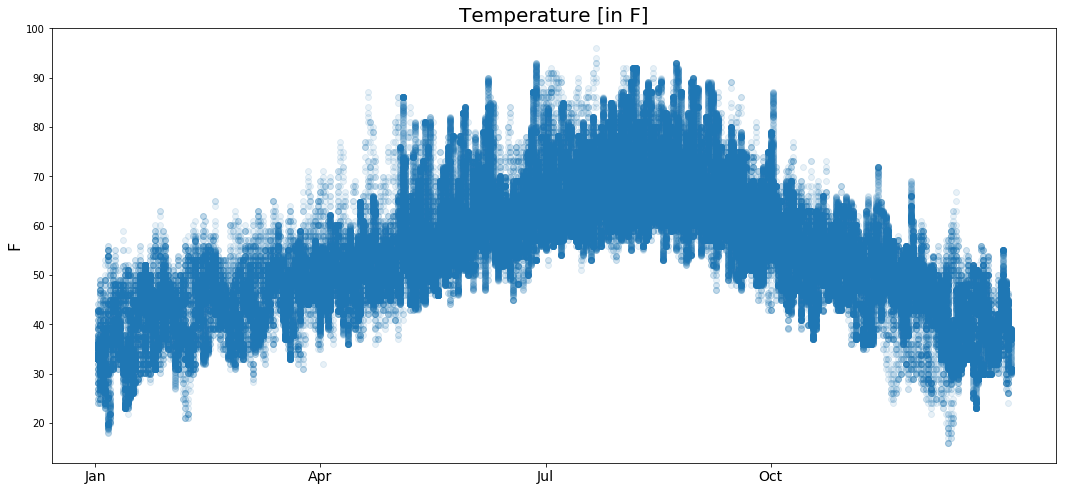

In [19]:
fig,ax = plt.subplots(figsize = (18,8))
ax.scatter(DF['doy'],DF['tmpf'], alpha = 0.1)
ax.set_title('Temperature [in F]',fontsize=20)
ax.set_ylabel('F', fontsize=16)
ax.set_xticks([0,90,180,270]) # choose which x locations to have ticks
ax.set_xticklabels(['Jan','Apr',"Jul",'Oct'], fontsize=14)

In [31]:
#Sweet way to push DF to Postgres DB


import io

from sqlalchemy import create_engine

# fail, append or replace

def write_to_table(df, db_engine, table_name, if_exists='fail'):
    string_data_io = io.StringIO()
    df.to_csv(string_data_io, sep='|', index=False)
    pd_sql_engine = pd.io.sql.pandasSQL_builder(db_engine)
    table = pd.io.sql.SQLTable(table_name, pd_sql_engine, frame=df,
                               index=False, if_exists=if_exists)
    table.create()
    string_data_io.seek(0)
    string_data_io.readline()  # remove header
    with db_engine.connect() as connection:
        with connection.connection.cursor() as cursor:
            copy_cmd = "COPY %s FROM STDIN HEADER DELIMITER '|' CSV" % table_name
            cursor.copy_expert(copy_cmd, string_data_io)
        connection.connection.commit()

In [32]:
address = 'postgresql://@localhost:5432/soaring_predictor'
engine = create_engine(address)

In [33]:
write_to_table(DF, engine, 'weather')